In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import src
from src.paleoseismic import PaleoseismicCatalog
import os
import yaml

# set the figure size and style
dpi = 200
mpl.rc('figure',dpi=dpi)
plt.style.use('tableau-colorblind10')
mpl.rc('font',size=10)

# set the data directory avoiding hardcoding the path
base_dir = Path(src.__file__).parents[1]
data_directory = base_dir/"data"

#### Available files records:

In [2]:
[print(f) for f in os.listdir(data_directory/"trench_records") if f.endswith('.txt')];

DSF_Qatar.txt
CSZ_central.txt
SAF_Pallett_Creek.txt
DSF_Beteiha.txt
SAF_Wrightwood.txt
SAF_Frasier_Mountian.txt
SJF_Hog_Lake.txt
AF_Lake_Paringa.txt
ATF_CopperMine10.txt
AF_Hokuri_Creek.txt
CSZ_south.txt
SAF_Noyo_Canyon.txt
SJF_Mystic_Lake.txt


In [3]:
filename = "SJF_Mystic_Lake.txt"

In [4]:
with open(data_directory/"metadata.yaml", "r") as f:
    meta_data = yaml.safe_load(f)

meta_data[filename]["end_time"] = 2025

trench_catalog = PaleoseismicCatalog(
    data_directory / "trench_records" / filename,
    **meta_data[filename],
)

print(yaml.dump(meta_data[filename], sort_keys=False))

trench_catalog.record.head()

start_time: null
end_time: 2025
gaps:
- - -900
  - -400
historic_events:
- 1812
notes: Historic event in 1812 A.D. Interval removed at sedimentary hiatus ca. 400-900
  B.C.
references:
- Onderdonk, N., McGill, S. & Rockwell, T. A 3700 yr paleoseismic record from the
  northern San Jacinto fault and implications for joint rupture of the San Jacinto
  and San Andreas faults. Geosphere (2018) doi:10.1130/GES01687.1.



,event,age,PDF,CDF
1,Event 16,-1664.5,0.000000e+00,0.000000e+00
2,Event 16,-1663.5,5.158988e-07,5.158988e-07
3,Event 16,-1662.5,5.158988e-07,1.031798e-06
4,Event 16,-1661.5,1.031798e-06,2.063595e-06
5,Event 16,-1660.5,5.158988e-07,2.579494e-06


/Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/waiting_time_paradox/src/paleoseismic.py:330: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


<Axes: xlabel='Calendar year', ylabel='Probability density'>

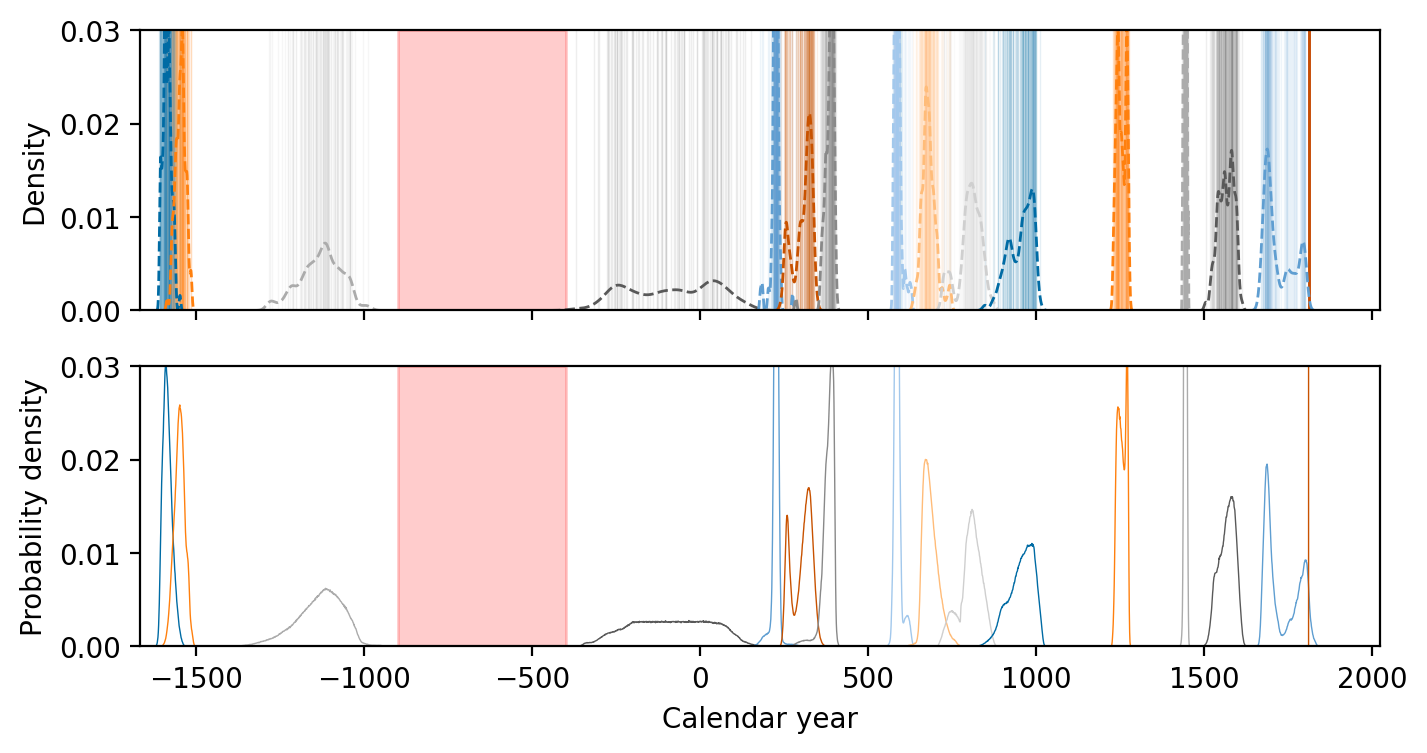

In [5]:
fig, AX = plt.subplots(2,1, sharex=True, figsize=(8,4), sharey=True, dpi=200)
trench_catalog.visualize_sampling(ax=AX[0])
trench_catalog.plot_pdfs(AX[1])

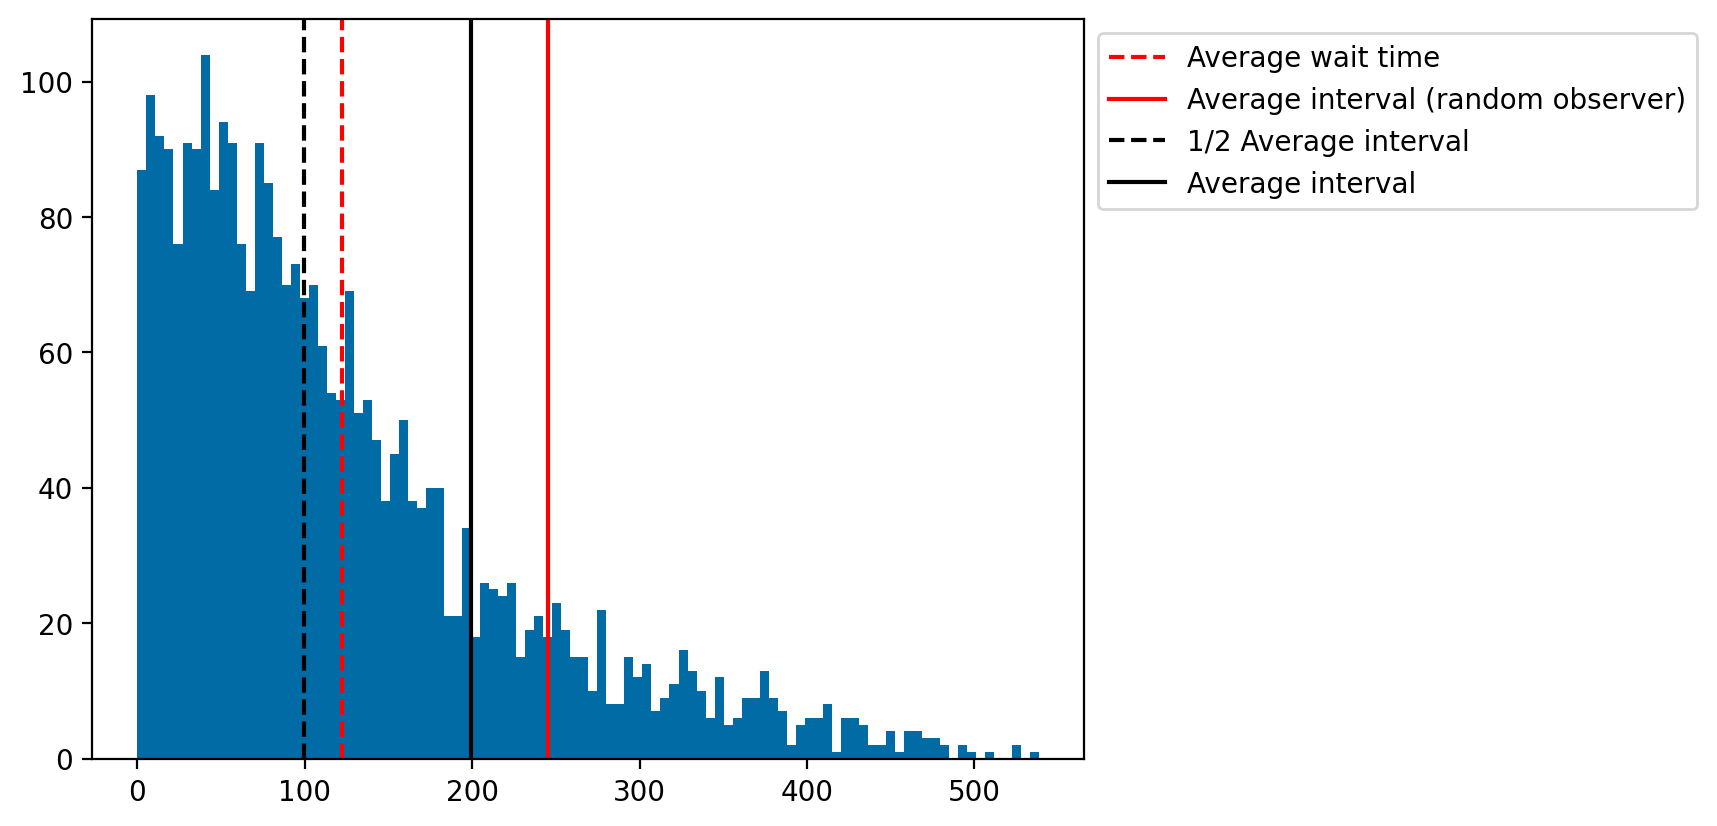

In [6]:
_, waiting_time, lapse_time = trench_catalog.visualize_waiting_time(number_of_samples=3000)

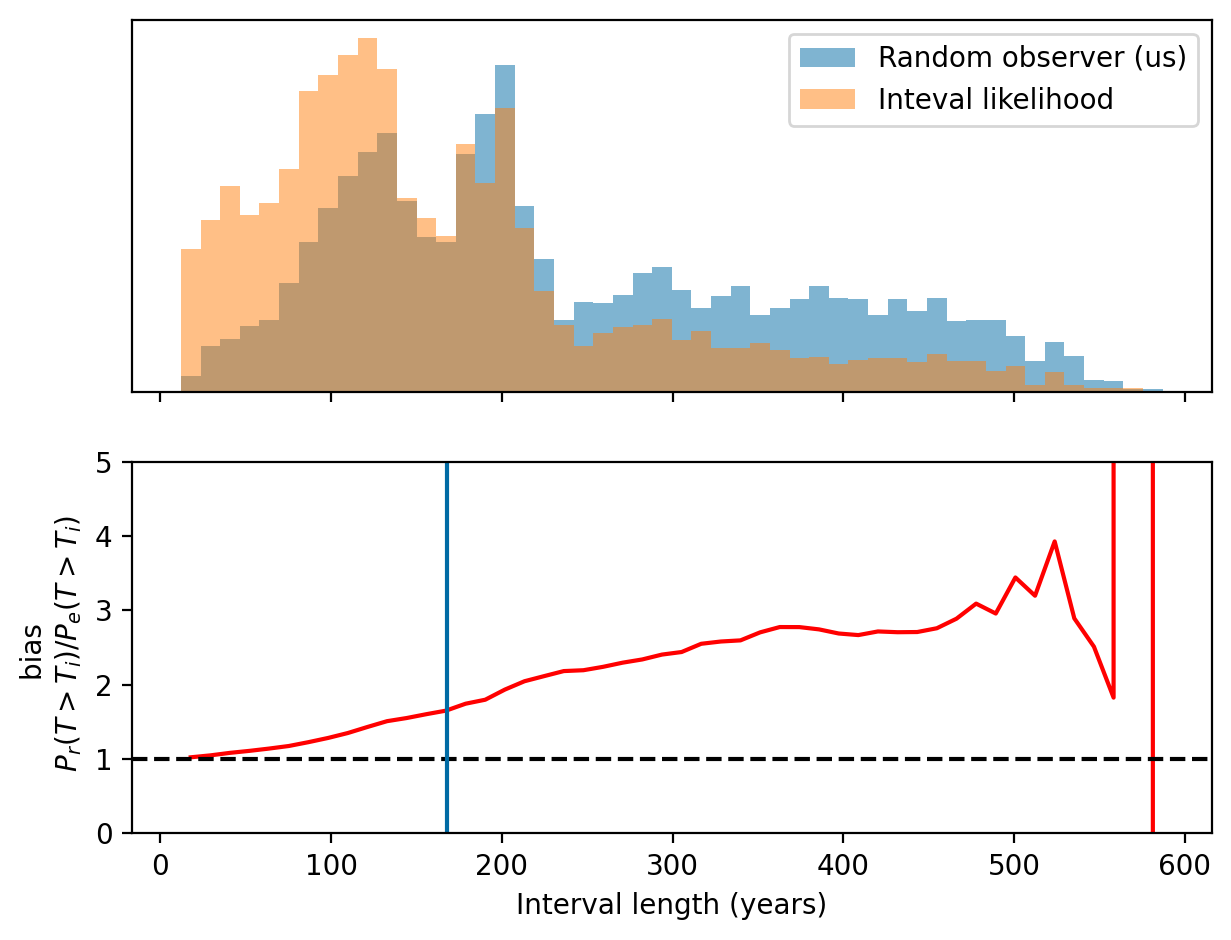

In [7]:
AX = trench_catalog.visualize_paradox(5000)
AX[1].axvline(2025-1857) # present day interval
AX[1].set(
    ylim=(0,5)
);

In [8]:
print(f"Expect to wait {np.nanmean(waiting_time)/trench_catalog.average_interval:0.2f} of the average interval ({filename})")

Expect to wait 0.61 of the average interval (SJF_Mystic_Lake.txt)


In [9]:
last_event = trench_catalog.get_events()[-1]
current_hiatus = 2025 - np.sum(last_event["PDF"] * last_event["age"])

number_of_samples = 1000

# the probability of a the hiatus (or a longer interval) is 1 - cdf, also known as the survival function
S_e = 1 - trench_catalog.ecdf(current_hiatus, number_of_samples, observer="event")
S_r = 1 - trench_catalog.ecdf(current_hiatus, number_of_samples, observer="random")

data = [
    ["Observer Type", "Empirical Probability"],
    ["Event", f"{S_e:0.2f}"],
    ["Random", f"{S_r:0.2f}"],
]

col_widths = [max(len(str(item)) for item in col) for col in zip(*data)]
for row in data:
    print(" | ".join(f"{item:<{col_widths[i]}}" for i, item in enumerate(row)))

Observer Type | Empirical Probability
Event         | 0.24                 
Random        | 0.45                 
